# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "cv_mod_resize_ver2"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
]

PROC_RAW = "proc/yolo11_cv_mod_resize2"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):

    image_paths = list_all_images(f"{PROC_YAML}/images")
    image_paths.sort()
    # print(image_paths)

    train_paths = []
    val_paths   = []

    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)
        else:
            train_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO("yolo11l.pt")  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=25,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize2/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize2/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=../../proc/yolo11_cv_mod_resize2/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=cv_mod_resize_ver2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 197.16it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 161.90it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_ver2/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(9a8cebb490f043759f4b73bc982e1402) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_ver2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        11G      2.018      2.329      1.457        468        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

                   all        184       2640      0.305      0.381      0.245     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25        11G      1.475      1.474      1.148        499        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        184       2640      0.434      0.521      0.438       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25        11G      1.363       1.34      1.101        302        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.476      0.514      0.517      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        11G      1.355      1.307      1.094        506        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.516      0.525       0.54      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        11G      1.299      1.244      1.072        525        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.535      0.579      0.568      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        11G      1.298      1.228      1.072        498        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2640       0.59      0.563      0.579      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25        11G      1.267      1.206       1.06        265        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.575      0.578      0.585      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        11G      1.244      1.188      1.049        317        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.584      0.578      0.602       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.9G       1.24      1.179      1.045        328        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2640       0.59      0.554      0.594       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.1G       1.21      1.148      1.035        387        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.563      0.608      0.614      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        11G      1.186      1.151      1.031        415        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.573      0.588      0.602      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25        11G      1.195      1.152       1.03        416        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640       0.58      0.579      0.604      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25        11G      1.201      1.122      1.031        626        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.636      0.577      0.601      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25        11G      1.181      1.109      1.027        464        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2640      0.563      0.566      0.572      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.1G       1.18      1.119      1.024        333        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.555      0.588      0.597      0.382


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      10.9G      1.075      1.054     0.9782        303        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.579      0.574      0.597      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      10.8G      1.075       1.04     0.9782        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.585      0.586      0.614      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      10.9G      1.075      1.036     0.9789        450        640: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.616      0.581      0.606      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25        11G      1.061      1.017     0.9748        284        640: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640      0.597      0.575      0.609       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25        11G      1.046      1.005     0.9676        369        640: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.592      0.603       0.61      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      10.9G      1.038     0.9898     0.9673        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        184       2640       0.59      0.598      0.611      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25        11G      1.028     0.9847     0.9631        360        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640       0.59      0.588      0.613      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25        11G      1.036     0.9919     0.9645        201        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640      0.587      0.598      0.615      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      10.9G      1.036     0.9883     0.9649        217        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640      0.594      0.593      0.616      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      10.9G      1.029     0.9845     0.9639        446        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.593      0.592      0.616      0.391



25 epochs completed in 0.225 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver2/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver2/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_ver2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


                   all        184       2640      0.589      0.588      0.613      0.398
          apo-ferritin        133        506      0.719      0.684      0.747      0.377
    beta-galactosidase        112        200      0.372       0.24      0.274       0.15
              ribosome        145        899      0.669      0.737      0.786      0.532
         thyroglobulin        144        749      0.348      0.327      0.287      0.174
   virus-like-particle        105        286      0.837      0.951       0.97      0.756
Speed: 0.2ms preprocess, 20.2ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_ver2
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize2/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize2/val.txt
New https://pypi.org/pr

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 1104 images, 220 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 197.52it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 168.80it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_ver22/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(f72a4737cac44ee88ee40521286eb1d1) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_ver22
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      2.006      2.345      1.453        479        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        184       2814      0.666     0.0669      0.249     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.6G      1.434      1.447      1.131        497        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2814      0.457      0.486      0.497       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G      1.349       1.33      1.097        273        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.468      0.509      0.529      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.333      1.298      1.084        515        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.473      0.537      0.555      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.283      1.236      1.065        525        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.499      0.534      0.564      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.273      1.229      1.065        457        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.546      0.559      0.562      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.239      1.201      1.051        253        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814       0.53      0.569      0.573      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.227      1.175      1.044        315        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.575      0.577      0.593      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.229      1.176      1.041        334        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.567      0.587      0.593      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.193      1.141       1.03        373        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.562      0.587      0.586      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.186      1.143      1.032        425        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.541      0.588      0.589      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.197      1.147      1.031        410        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.556      0.587      0.588      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.187      1.117      1.026        598        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.538      0.572      0.589      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.162      1.103      1.022        456        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        184       2814      0.557        0.6      0.583      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G       1.17      1.109      1.021        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        184       2814      0.549      0.592      0.591      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G       1.07      1.041     0.9775        336        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.577      0.593      0.594      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.053      1.011     0.9708        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.562      0.611      0.597      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.056      1.016     0.9734        449        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2814       0.58      0.605      0.598      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.048     0.9903     0.9709        283        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2814      0.592      0.608      0.594      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      1.037       0.99     0.9645        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.582        0.6      0.595      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.027     0.9667     0.9636        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.597      0.601      0.598      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G      1.016     0.9586     0.9591        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.584      0.602        0.6      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.023     0.9668       0.96        226        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       2814      0.578      0.602        0.6      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.022     0.9578     0.9603        204        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.584      0.605      0.602       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.018     0.9544     0.9598        391        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2814      0.589      0.602      0.601      0.387



25 epochs completed in 0.228 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver22/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver22/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_ver22/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


                   all        184       2814      0.582      0.603        0.6      0.397
          apo-ferritin         75        385      0.614      0.696      0.654      0.336
    beta-galactosidase         86        272      0.401      0.169      0.222      0.116
              ribosome         96       1073      0.773      0.833       0.88      0.616
         thyroglobulin        100        850      0.388      0.362      0.285      0.173
   virus-like-particle         56        234      0.736      0.957       0.96      0.744
Speed: 0.2ms preprocess, 7.5ms inference, 0.0ms loss, 23.3ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_ver22
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize2/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize2/val.txt
New https://pypi.org/pro

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:06<00:00, 175.18it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 155.98it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_ver23/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(b95f5e81e1c54ee49b916dc10a9c2e10) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_ver23
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      2.029       2.41      1.461        461        640: 100%|██████████| 69/69 [00:32<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        184       3998      0.336      0.429        0.3      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.443      1.506      1.132        473        640: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        184       3998      0.638      0.412      0.398      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G       1.33      1.354      1.086        257        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        184       3998      0.483      0.547      0.501      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.322      1.316      1.078        447        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.577      0.532      0.517      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.5G      1.286      1.255      1.064        511        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3998      0.533       0.56      0.525      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.264      1.247      1.057        439        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.494      0.585      0.529      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.251      1.223      1.054        207        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        184       3998      0.526      0.584      0.538       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G       1.23      1.193      1.042        312        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.608      0.574      0.547      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.217      1.181      1.034        309        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.566      0.574      0.552      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.192      1.159      1.028        375        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.555      0.573      0.554       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.167       1.15      1.022        429        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        184       3998      0.552      0.585      0.563      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.177      1.165      1.021        385        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.574      0.576      0.564      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G       1.18      1.128      1.022        583        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.543       0.58      0.565      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.147      1.116      1.015        436        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       3998       0.56      0.576      0.562      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G      1.159      1.119      1.017        333        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.537      0.583      0.561      0.341


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.058      1.056     0.9721        325        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.566      0.572      0.568      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.042      1.033     0.9655        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.552      0.593      0.569      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.042      1.024     0.9655        442        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.553       0.59      0.573      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.032      1.009     0.9644        260        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        184       3998      0.564      0.589      0.575      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      1.027      1.002     0.9607        339        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.569      0.581      0.573      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.017     0.9877     0.9596        336        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.571      0.591      0.575      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G       1.01     0.9832     0.9559        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       3998      0.561      0.599      0.579      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.012     0.9777     0.9554        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.571      0.597      0.579      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.012     0.9711     0.9572        191        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        184       3998      0.565      0.597      0.579      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G       1.01     0.9704     0.9559        362        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.564      0.598      0.579      0.343



25 epochs completed in 0.232 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver23/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver23/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_ver23/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


                   all        184       3998      0.561      0.599      0.578      0.352
          apo-ferritin        121        638      0.628      0.777      0.743      0.377
    beta-galactosidase         89        204      0.393      0.216      0.277      0.112
              ribosome        129       2146      0.633      0.887      0.774      0.508
         thyroglobulin        125        750      0.397      0.408      0.343      0.181
   virus-like-particle         75        260      0.755      0.708      0.755       0.58
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_ver23
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_mod_resize2/train.txt
Val list saved to ../../proc/yolo11_cv_mod_resize2/val.txt
New https://pypi.org/proj

train: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 1104 images, 278 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 198.29it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_mod_resize2/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 168.21it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_mod_resize2/labels.cache


Plotting labels to /workspace/CZII/runs/detect/cv_mod_resize_ver24/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(5a45b58e30d34371bb6ff1f12d7180c4) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/cv_mod_resize_ver24
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.987       2.34       1.44        529        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        184       2674      0.359      0.432      0.314     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.413       1.42      1.123        492        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        184       2674      0.482      0.509      0.493      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G       1.34      1.327      1.091        260        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674       0.51      0.538      0.528      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.325      1.287      1.081        460        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.516      0.555      0.551      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.269      1.221      1.061        536        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.517      0.602      0.575      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.262      1.229      1.061        476        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.557      0.592      0.569      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.248      1.219      1.054        223        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        184       2674      0.518      0.609      0.573       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.223      1.176      1.041        314        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]

                   all        184       2674      0.523      0.603      0.589      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.226      1.172       1.04        385        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.542       0.61      0.588      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.204      1.139      1.036        385        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.574      0.613      0.607      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.175      1.135      1.028        469        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.547      0.634      0.607      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.181      1.148      1.025        424        640: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       2674      0.566      0.617      0.594      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.197      1.121      1.029        611        640: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        184       2674      0.586      0.609      0.596      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.172      1.118      1.025        482        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2674      0.574      0.614      0.604      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G       1.17       1.11      1.022        332        640: 100%|██████████| 69/69 [00:29<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        184       2674      0.578      0.609      0.609      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.073      1.056     0.9781        325        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.588      0.615       0.61      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G      1.056      1.034     0.9719        363        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.588      0.609      0.611      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G       1.05      1.019     0.9684        439        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.636      0.602       0.62      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.046     0.9911     0.9701        260        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        184       2674      0.612      0.611       0.61      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.033     0.9905     0.9644        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        184       2674      0.596      0.624      0.612      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.031     0.9757     0.9652        332        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        184       2674      0.597       0.62      0.614      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      1.025     0.9724      0.961        365        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674        0.6      0.621      0.611      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.022     0.9708     0.9599        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        184       2674      0.601       0.62      0.607      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.022     0.9631     0.9619        215        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

                   all        184       2674      0.612      0.614      0.609      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.023     0.9604     0.9614        395        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        184       2674      0.608      0.615      0.609      0.377



25 epochs completed in 0.257 hours.
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver24/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/cv_mod_resize_ver24/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/cv_mod_resize_ver24/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


                   all        184       2674      0.636      0.602       0.62      0.388
          apo-ferritin        149        451      0.652       0.69       0.68      0.368
    beta-galactosidase         84        187       0.51      0.257      0.302      0.155
              ribosome        106        667      0.896      0.745      0.888      0.537
         thyroglobulin        144        875      0.331      0.401      0.283      0.166
   virus-like-particle        127        494      0.791      0.919      0.945      0.712
Speed: 0.2ms preprocess, 35.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /workspace/CZII/runs/detect/cv_mod_resize_ver24
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.593,0.592,0.616,0.391
val_TS_69_2,0.589,0.602,0.601,0.387
val_TS_6_4,0.564,0.598,0.579,0.343
val_TS_6_6,0.608,0.615,0.609,0.377
mean,0.589,0.602,0.601,0.375


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

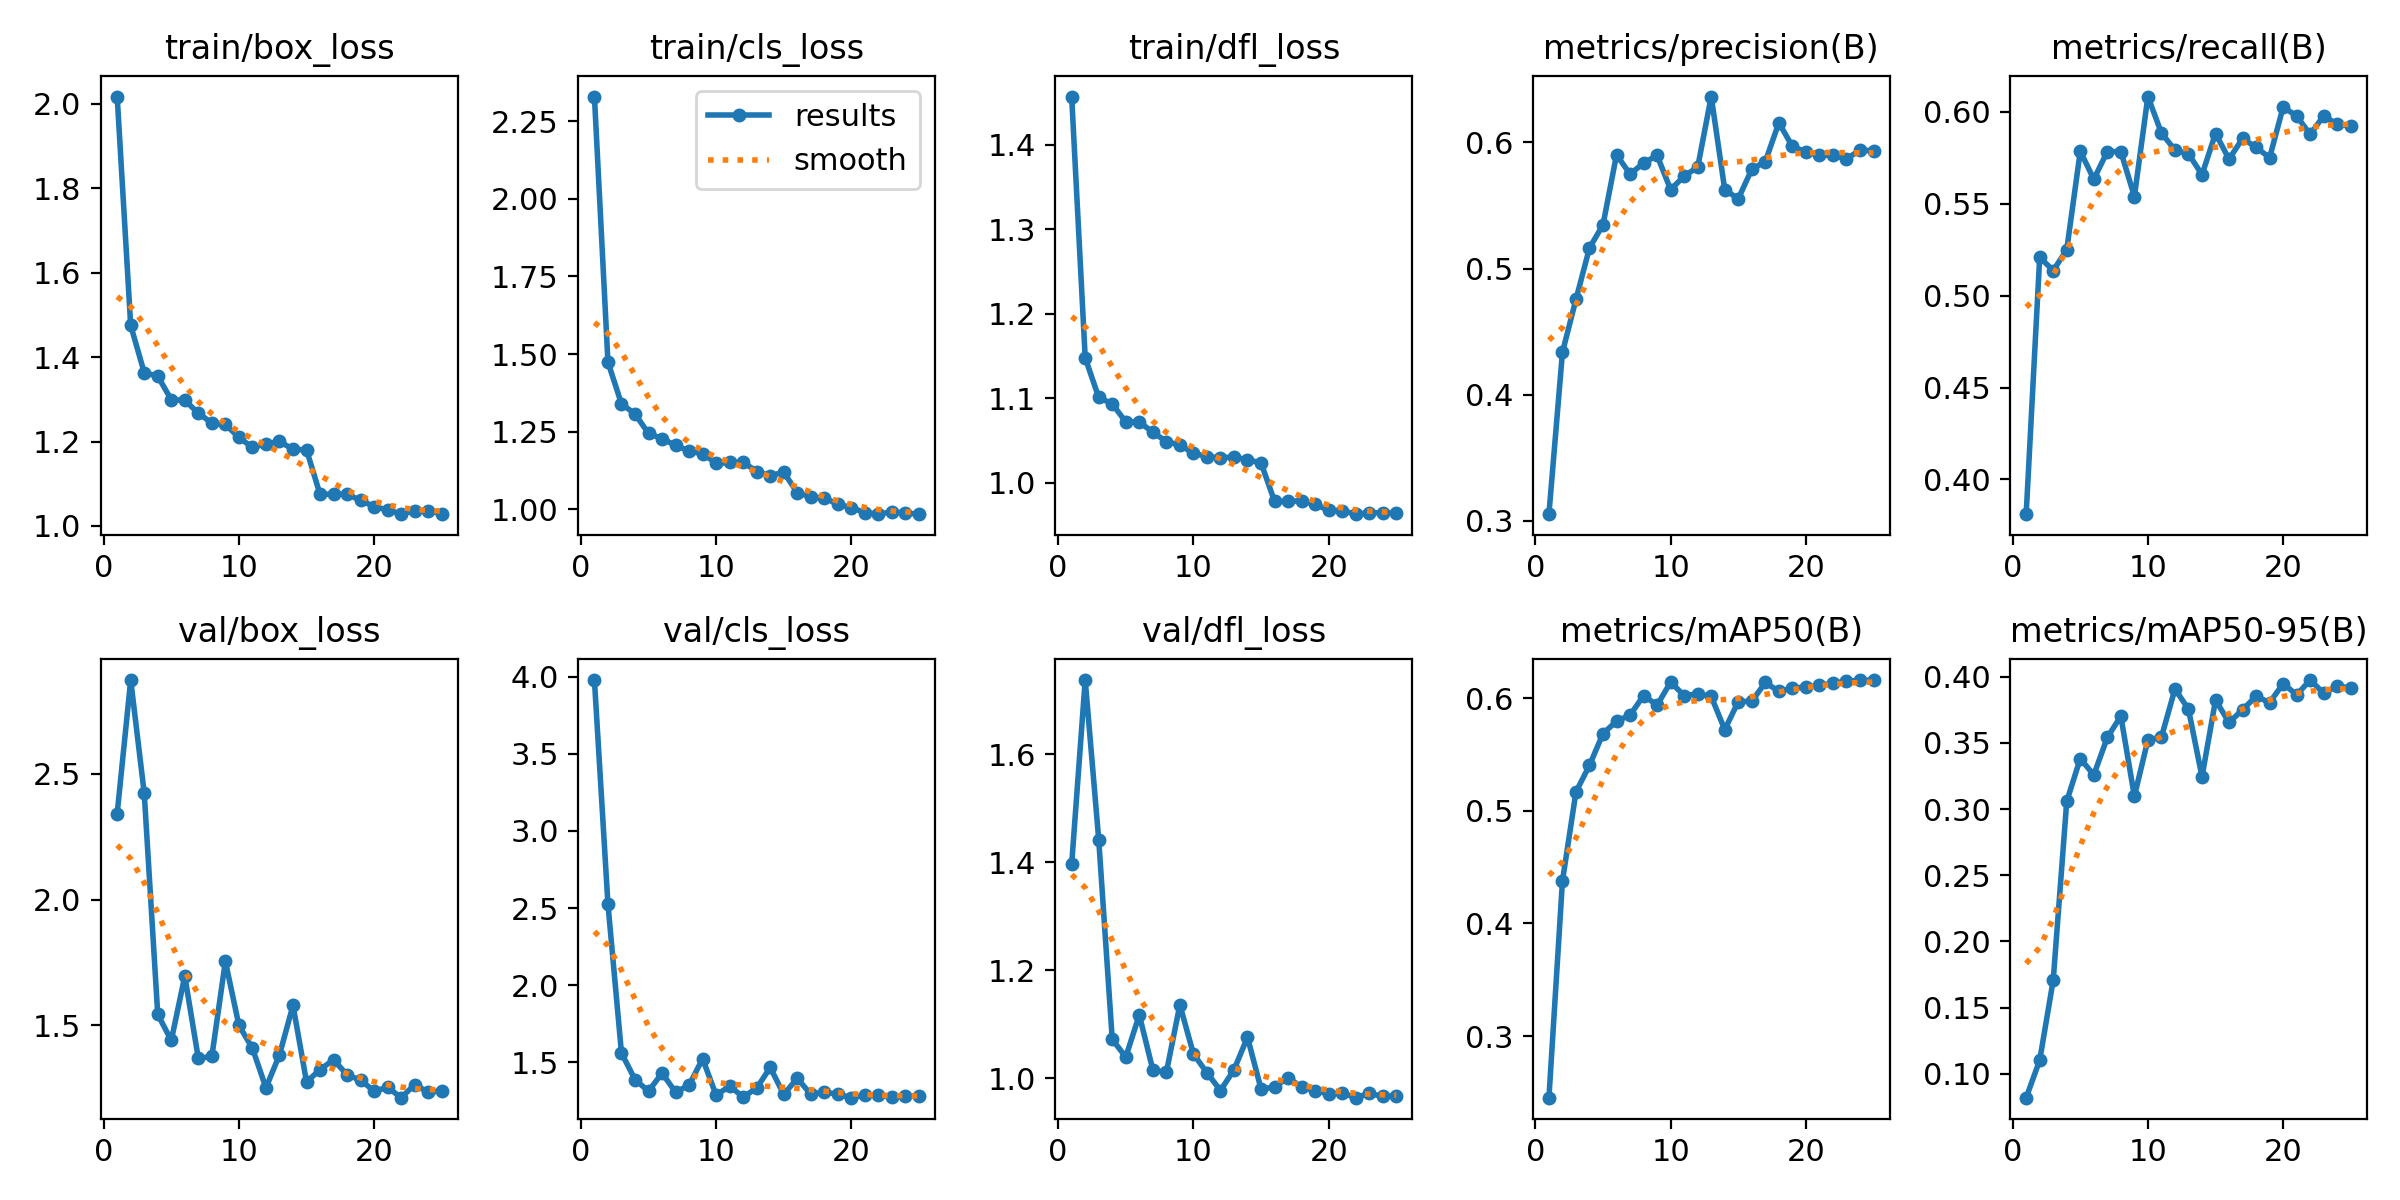

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)

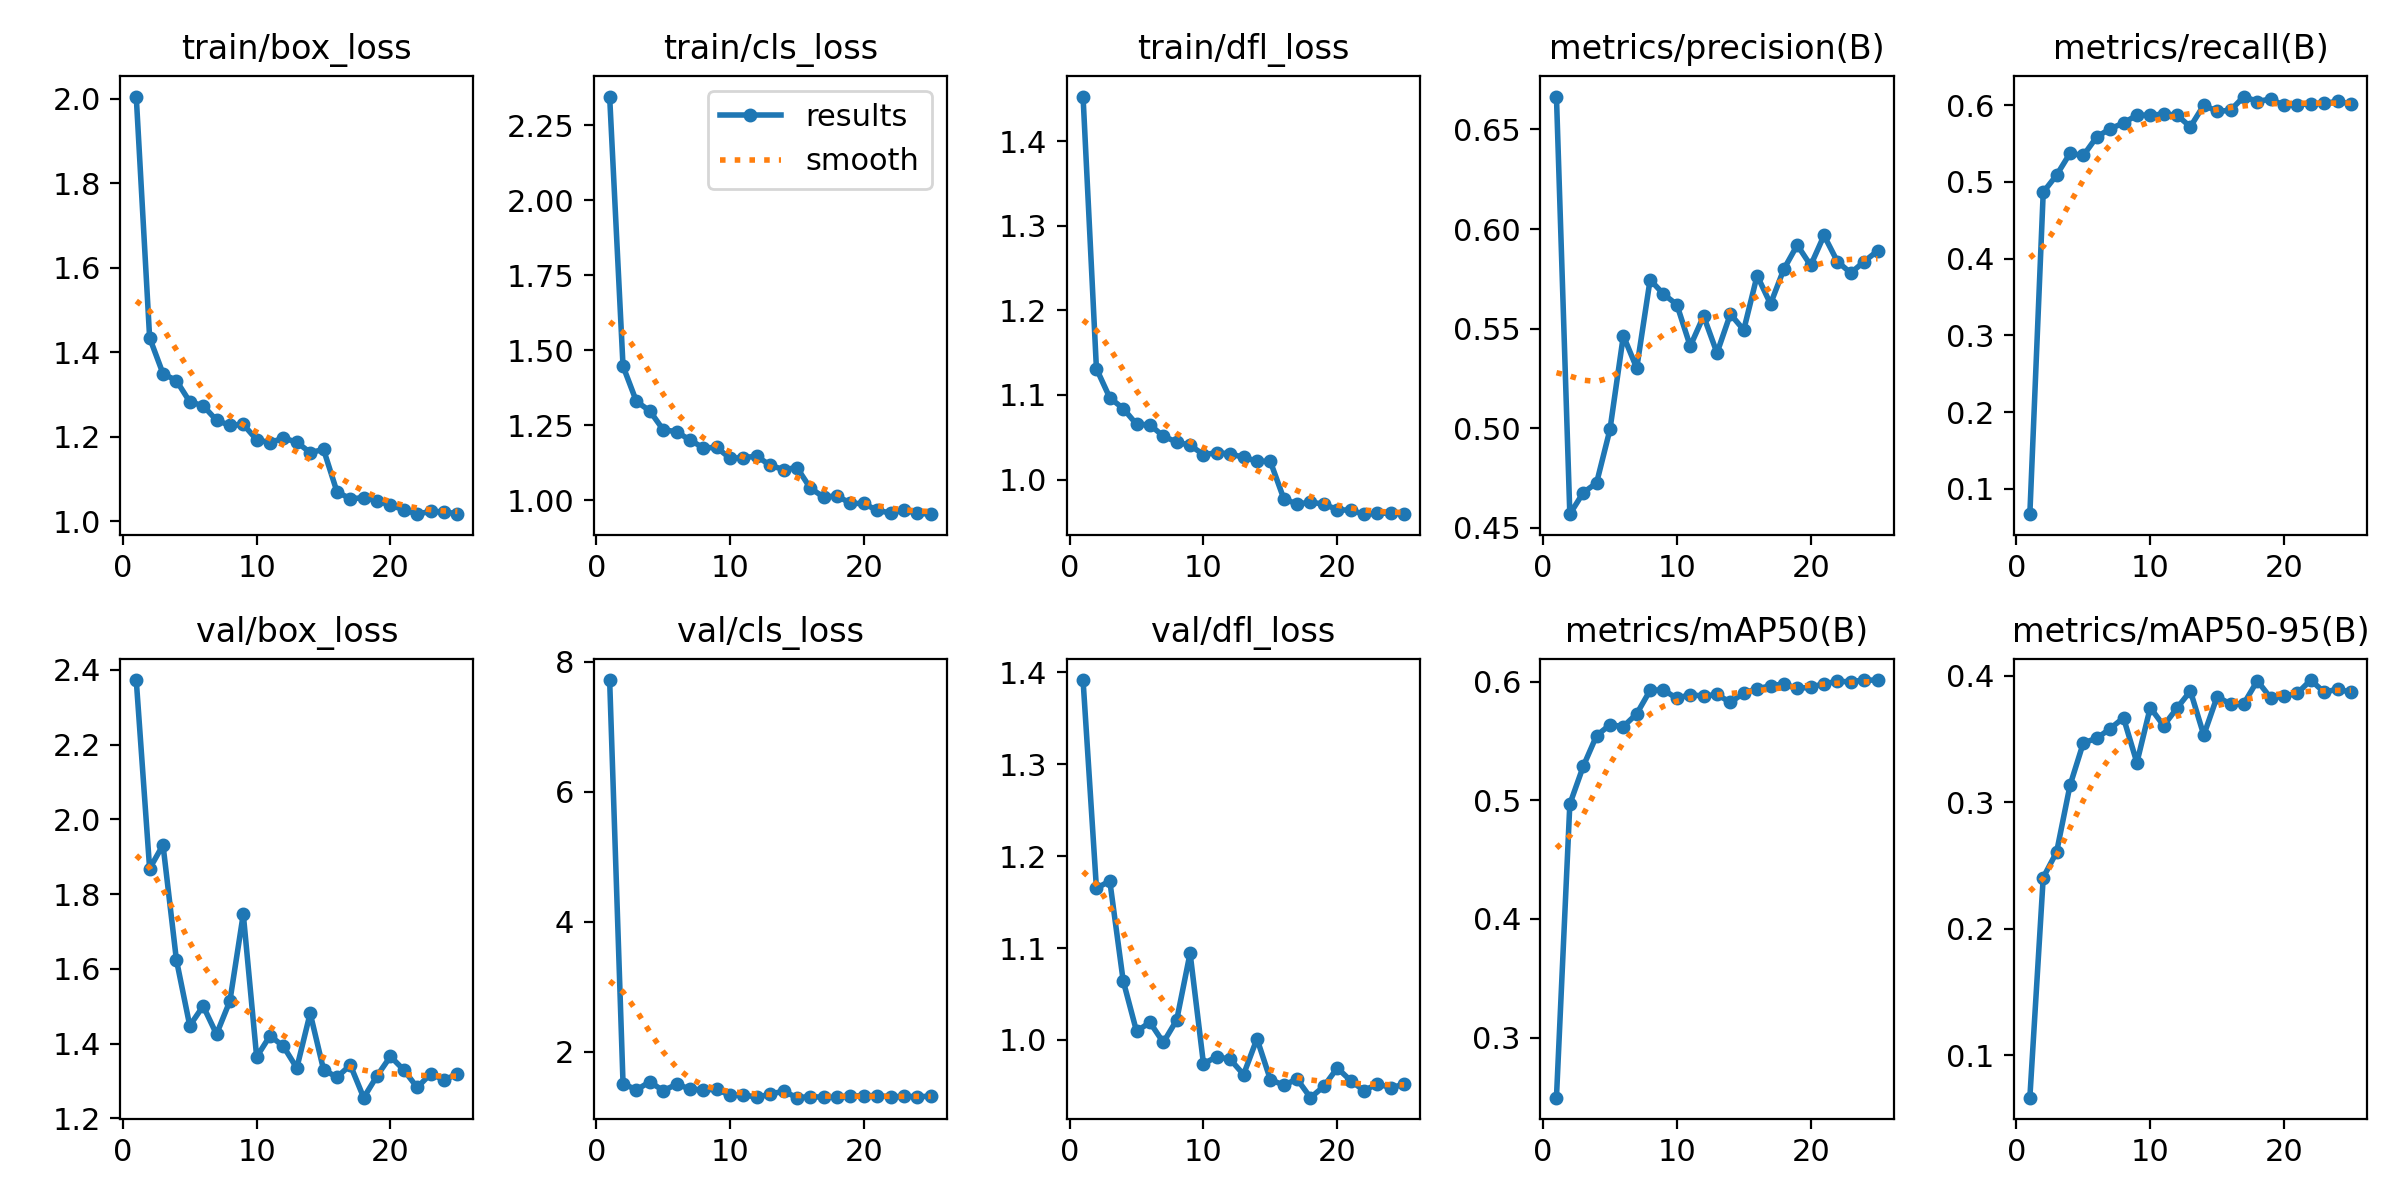

In [11]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}2/results.png', width=800)

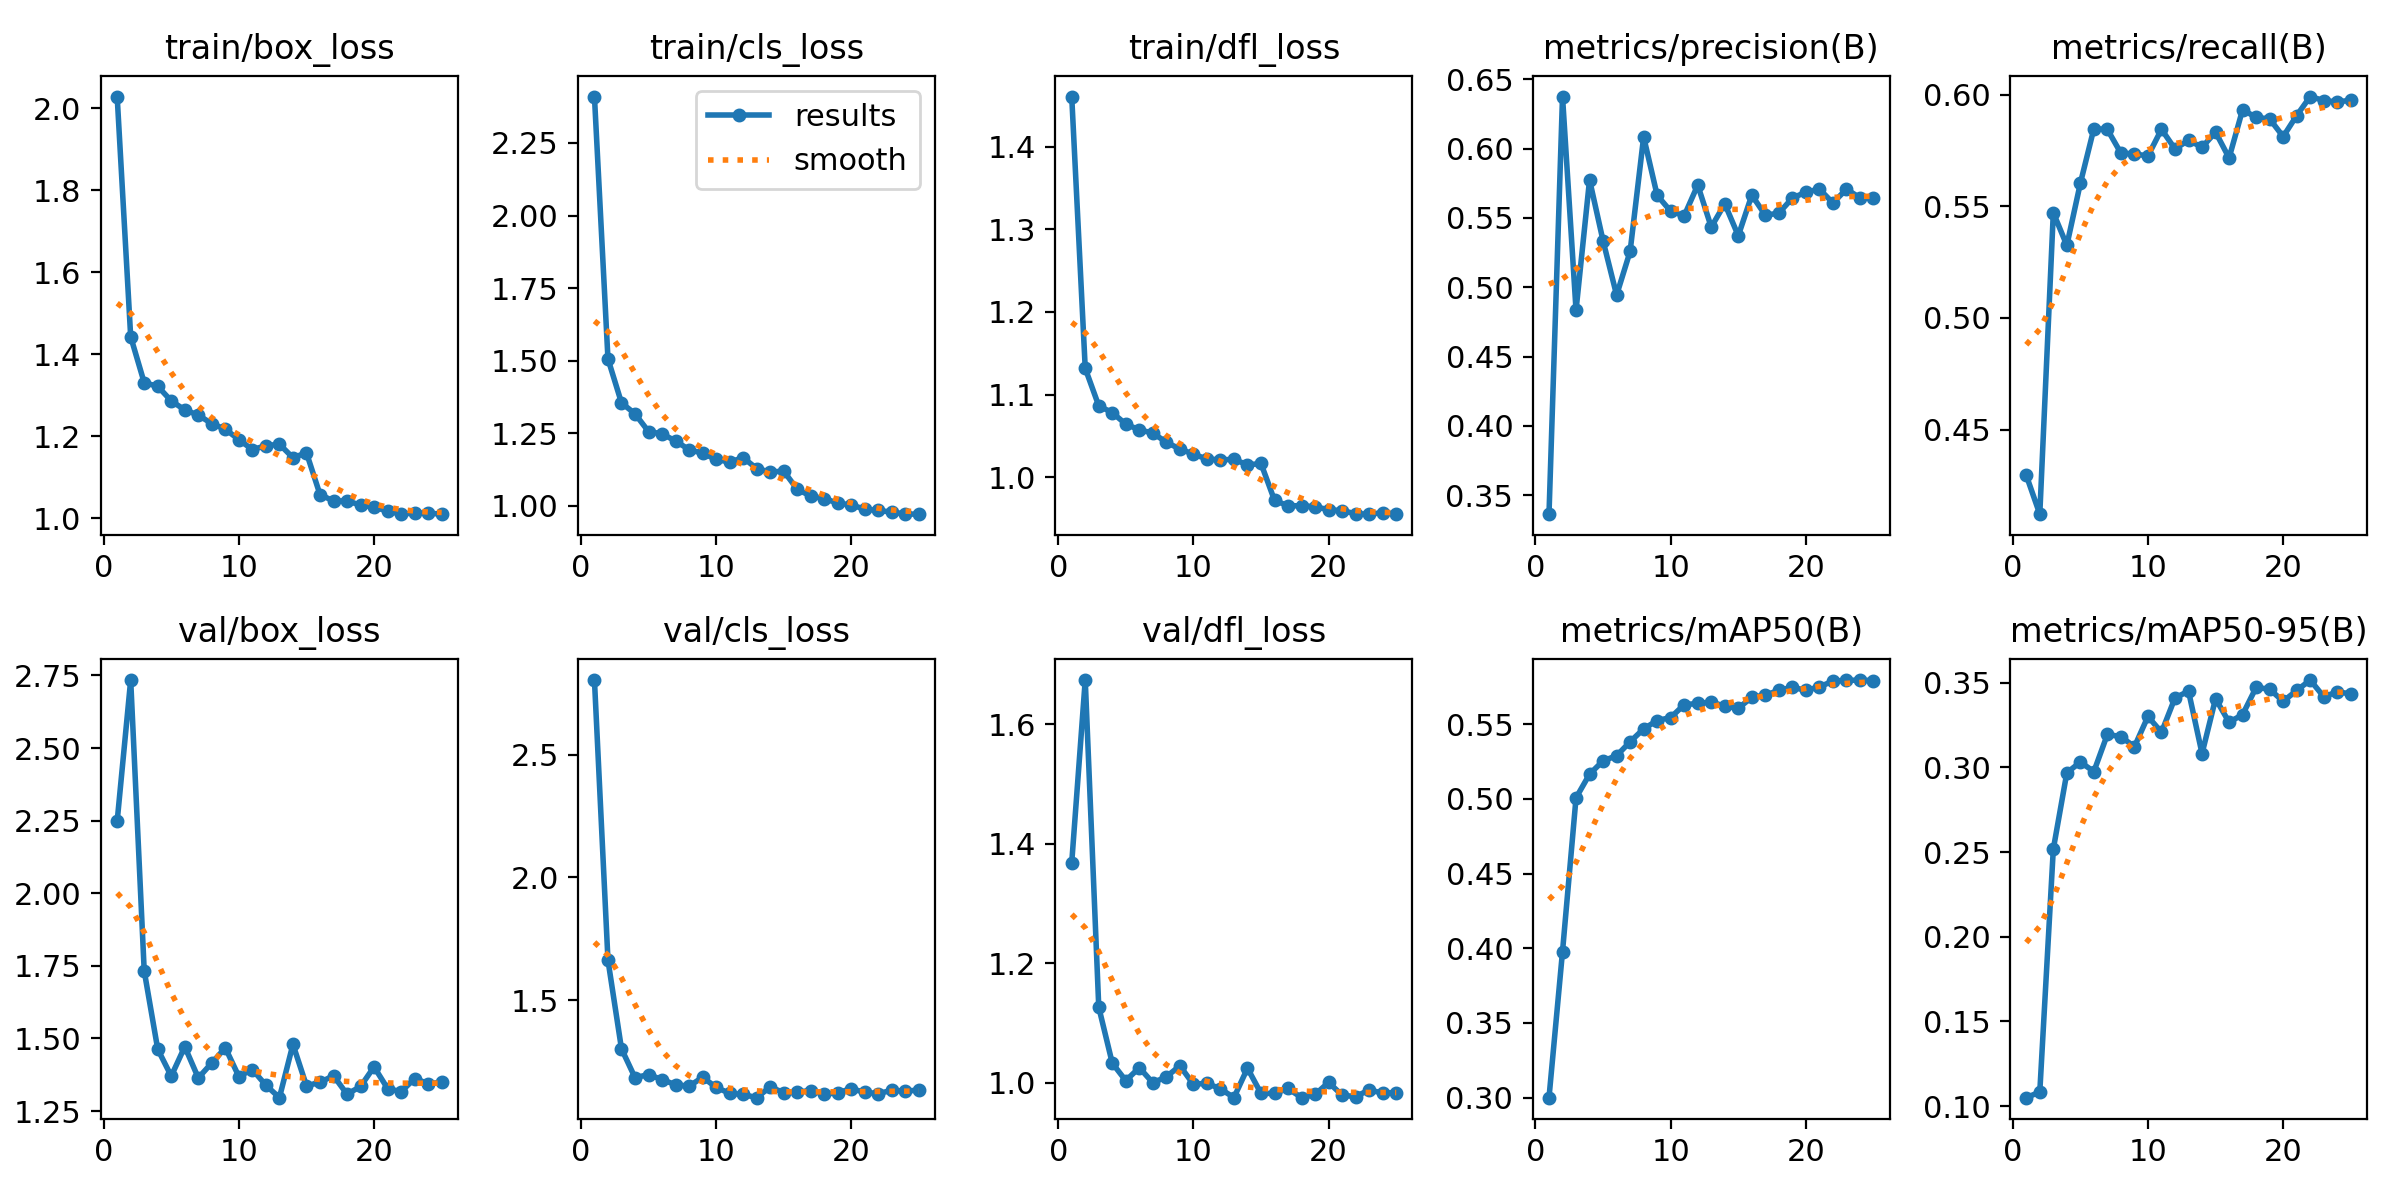

In [12]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}3/results.png', width=800)

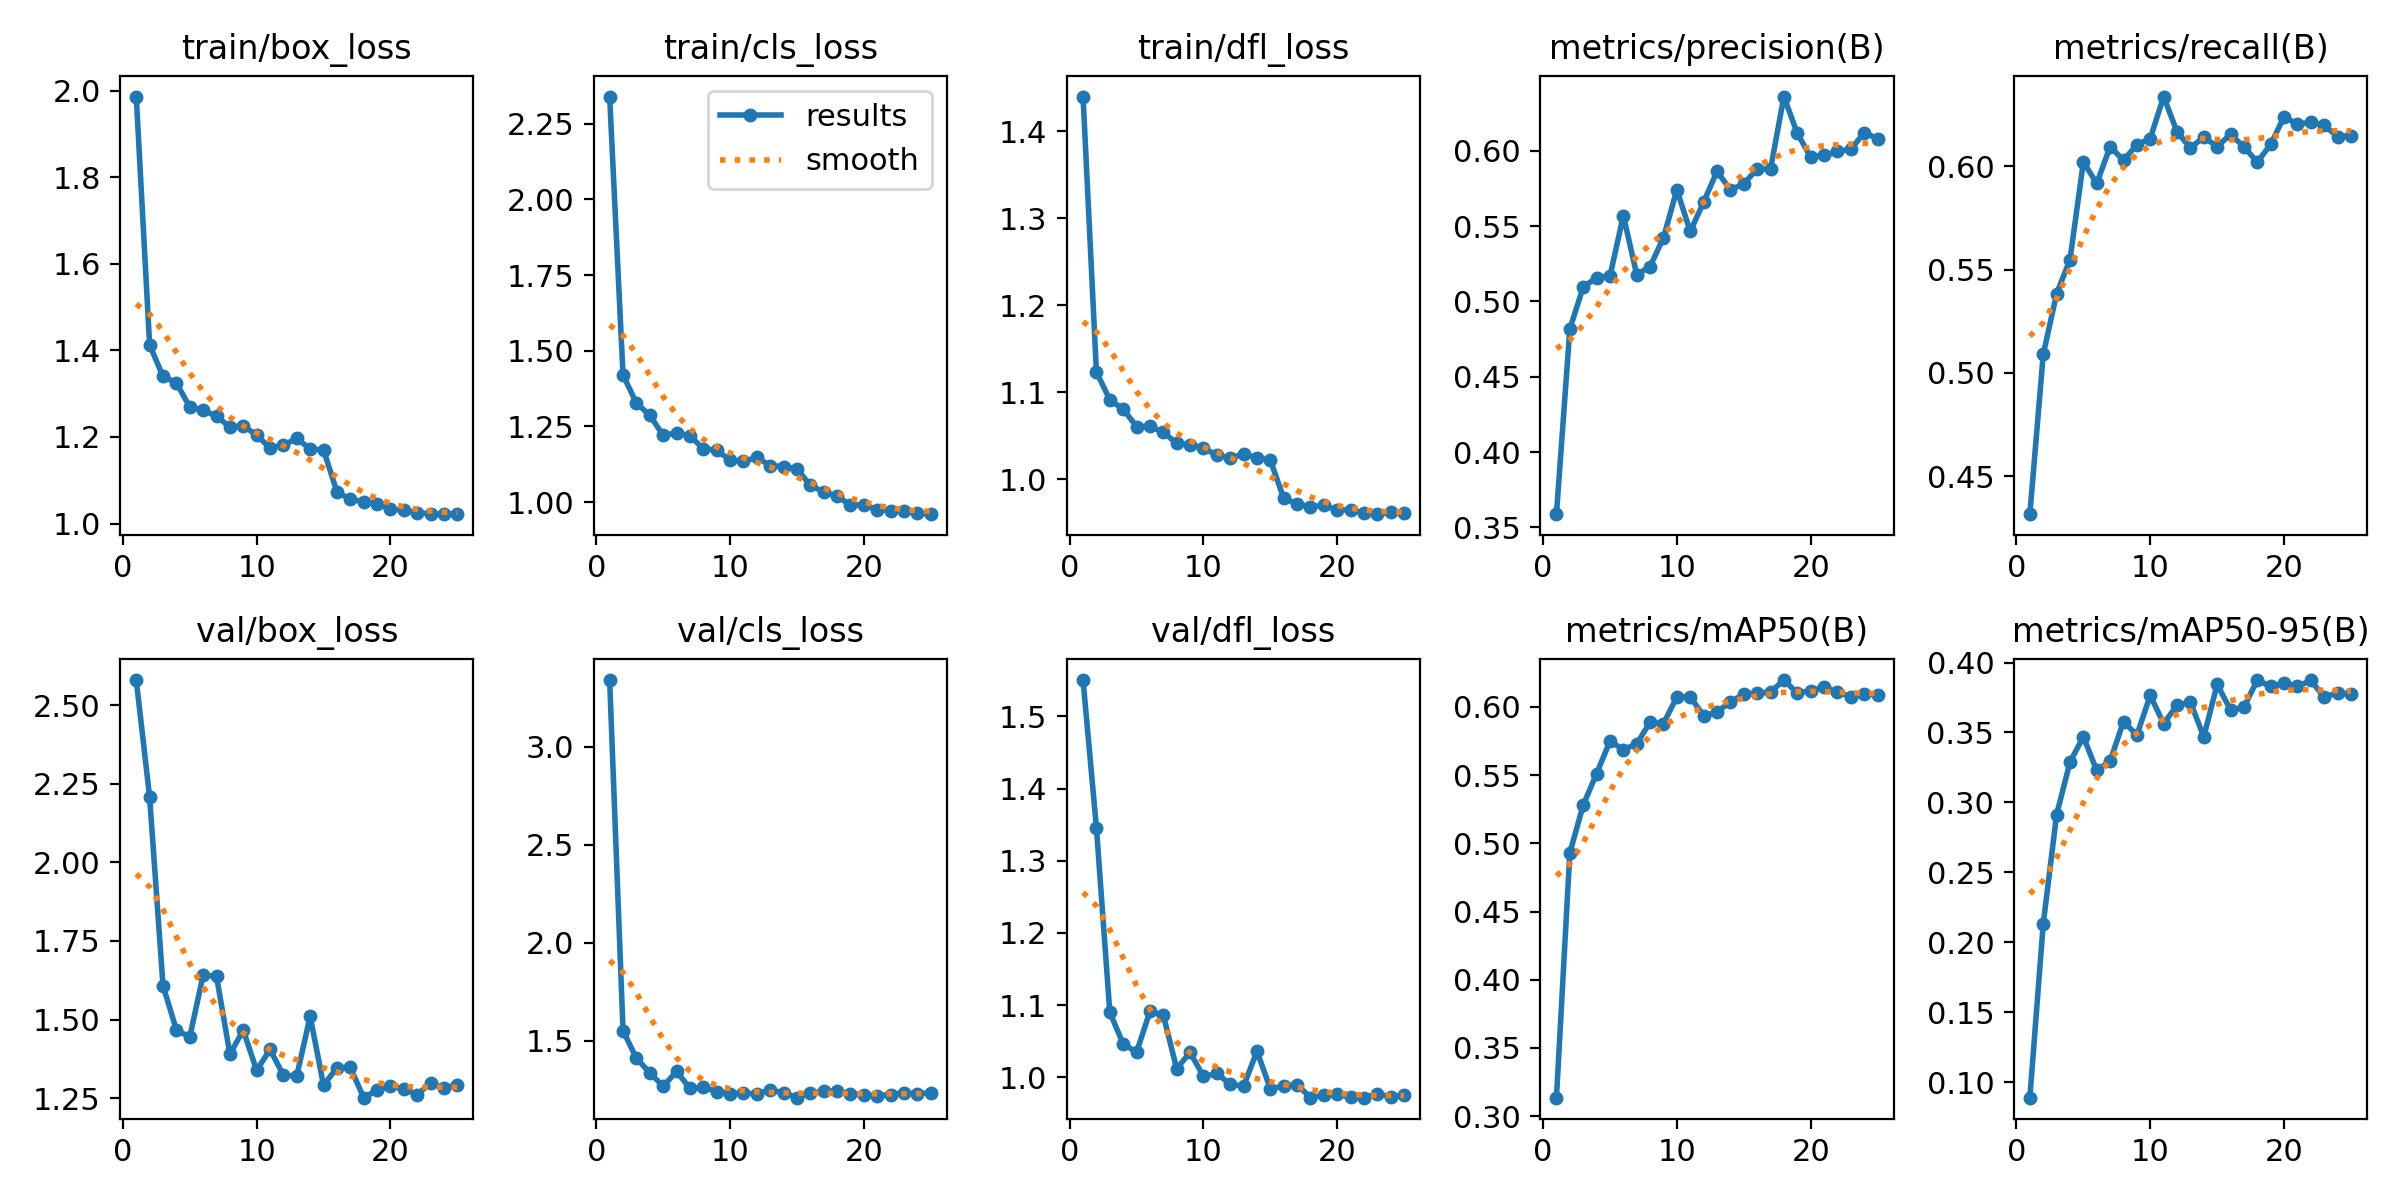

In [13]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}4/results.png', width=800)